In [1]:
import mlxtend
import numpy as np
import pandas as pd
import re
import time
from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import time

from scipy import stats
from numpy.linalg import norm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import k_means_

from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.metrics import silhouette_score

from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns; sns.set(style="ticks", color_codes=True)

# Resumo

O objetivo deste notbook é executar o trablho da disciplina de Data Mining I. O enunciado pedia que:

# Importando o dataset

dataset depois do tratamento feito para a análise de Market Basket. 

In [2]:
ratingsDF_100k = pd.read_pickle("..\\ProcessedData\\df.pkl")
ratingsDF_1M = pd.read_pickle("..\\ProcessedData\\df_1M.pkl")

visualizando dataset 100k

In [3]:
ratingsDF_100k.head()

,uid,id,rating,timestamp,movie_title,release_date,IMDb_URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,1997-12-04 15:55:49,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,242,3,1997-10-01 23:06:30,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,226,242,5,1998-01-04 04:37:51,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,154,242,3,1997-11-10 05:03:55,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,306,242,5,1997-10-10 17:16:33,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0


visualizando dataset 1M

In [4]:
ratingsDF_1M.head()

,uid,id,rating,timestamp,movie_title,Genres
0,1,1193,5,2000-12-31 22:12:40,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama
1,2,1193,5,2000-12-31 21:33:33,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama
2,12,1193,4,2000-12-30 23:49:39,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama
3,15,1193,4,2000-12-30 18:01:19,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama
4,17,1193,5,2000-12-30 06:41:11,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama


In [5]:
print("Número de usuários na base 100k %i" % ratingsDF_100k['uid'].nunique())
print("Número de usuários na base 1M %i" % ratingsDF_1M['uid'].nunique())

Número de usuários na base 100k 943
Número de usuários na base 1M 6040


In [6]:
print("Número de filmes na base 100k %i" % ratingsDF_100k['id'].nunique())
print("Número de filmes na base 1M %i" % ratingsDF_1M['id'].nunique())

Número de filmes na base 100k 1664
Número de filmes na base 1M 3706


## Criando os vetores de features dos filmes

Cada filme será representado pelas notas que cada um dos usuários da base deu para aquele filme. O que siginifica que **cada filme será representado por vetores esparsos de tamanho 943**.

Sabemos da exploração que não há duplicatas para a chave **uid, id**, então:

In [7]:
def visualize_ratings_sparsity(ratingsDF):
    ratings_id = ratingsDF.groupby(['id']).aggregate({'rating': len})
    
    print("Moda do número de usuários que viram o filme: %i" % ratings_id.rating.mode())
    print("Média do número de usuários que viram o filme: %i" % ratings_id.rating.mean())
    print("Número de filmes com apenas uma avaliação: %i" % (ratings_id.rating == 1).sum())
    
    plt.figure(),
    plt.subplot(1,2,1)
    ratings_id.rating.hist()
    plt.grid(True)
    plt.title("#usuários que viram o filme")
    plt.xlabel("uid")
    plt.ylabel("freq absoluta")

    plt.subplot(1,2,2)
    ratings_id.boxplot()
    plt.title("Boxplot que viram o filme")
    plt.rcParams['figure.figsize'] = (11,7)
    plt.show()
    
    return ratings_id

Esparsidade do vetor de features na base de 100k 

Moda do número de usuários que viram o filme: 1
Média do número de usuários que viram o filme: 59
Número de filmes com apenas uma avaliação: 135


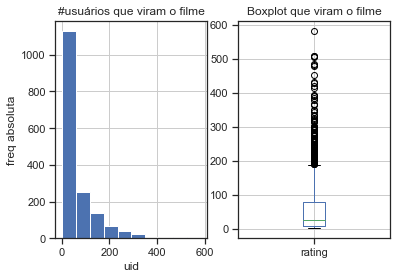

In [8]:
ratings_id_100k = visualize_ratings_sparsity(ratingsDF_100k)

Esparsidade do vetor de features na base de 1M 

Moda do número de usuários que viram o filme: 1
Média do número de usuários que viram o filme: 269
Número de filmes com apenas uma avaliação: 114


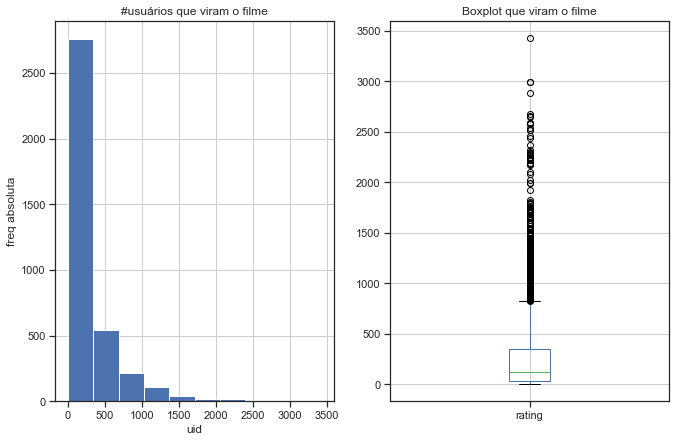

In [9]:
ratings_id_1M = visualize_ratings_sparsity(ratingsDF_1M)

## Filmes mais vistos

Para depois acharmos quais so clusters dos filmes mais populares vamos determinar quais sã eles primeiro. Após a observação dos box plot que mostram o quão esparsos são os vetores das bases, pode-se considerar que um filme popular na base de 100k tem pelo meos 150 visualizações e na base de 1M pelo menos 750

In [10]:
def determine_popular_filmss(ratings_id, threshold):
    popular_film = (ratings_id.rating > threshold)
    popular_ids = popular_film[popular_film]
    print("número de filmes populares %i" % popular_film.sum())
    return popular_ids

Para a base de 100k

In [11]:
popular_ids_100k = popular_ids_100k = determine_popular_filmss(ratings_id_100k, 150)

número de filmes populares 202


In [12]:
ratingsDF_100k[ratingsDF_100k['id'].isin(popular_ids_100k.index)].sample(10)

,uid,id,rating,timestamp,movie_title,release_date,IMDb_URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
825,407,474,3,1997-09-23 19:19:38,Dr. Strangelove or: How I Learned to Stop Worr...,1963-01-01,http://us.imdb.com/M/title-exact?Dr.%20Strange...,0,0,0,...,0,0,0,0,0,0,1,0,1,0
45128,186,71,5,1997-11-08 21:28:55,"Lion King, The (1994)",1994-01-01,"http://us.imdb.com/M/title-exact?Lion%20King,%...",0,0,0,...,0,0,0,1,0,0,0,0,0,0
25089,619,79,5,1998-01-28 02:19:52,"Fugitive, The (1993)",1993-01-01,"http://us.imdb.com/M/title-exact?Fugitive,%20T...",0,1,0,...,0,0,0,0,0,0,0,1,0,0
77157,152,527,4,1997-12-18 20:35:56,Gandhi (1982),1982-01-01,http://us.imdb.com/M/title-exact?Gandhi%20(1982),0,0,0,...,0,0,0,0,0,0,0,0,0,0
24961,472,79,5,1998-04-17 05:29:13,"Fugitive, The (1993)",1993-01-01,"http://us.imdb.com/M/title-exact?Fugitive,%20T...",0,1,0,...,0,0,0,0,0,0,0,1,0,0
28669,332,235,3,1998-02-20 01:38:43,Mars Attacks! (1996),1996-12-13,http://us.imdb.com/M/title-exact?Mars%20Attack...,0,1,0,...,0,0,0,0,0,0,1,0,1,0
80898,851,313,4,1997-12-26 15:03:47,Titanic (1997),1997-01-01,http://us.imdb.com/M/title-exact?imdb-title-12...,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8449,178,181,5,1997-12-22 20:50:32,Return of the Jedi (1983),1997-03-14,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,...,0,0,0,0,0,1,1,0,1,0
5159,117,98,4,1997-12-01 21:40:30,"Silence of the Lambs, The (1991)",1991-01-01,http://us.imdb.com/M/title-exact?Silence%20of%...,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17386,538,174,4,1997-10-17 16:43:39,Raiders of the Lost Ark (1981),1981-01-01,http://us.imdb.com/M/title-exact?Raiders%20of%...,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
popular_ids_1M = popular_ids_100k = determine_popular_filmss(ratings_id_1M, 750)

número de filmes populares 354


In [14]:
ratingsDF_1M[ratingsDF_1M['id'].isin(popular_ids_1M.index)].sample(10)

,uid,id,rating,timestamp,movie_title,Genres
133479,178,1198,4,2000-12-18 00:19:17,RAIDERS OF THE LOST ARK (1981),Action|Adventure
531594,3462,1073,2,2000-08-30 03:05:14,WILLY WONKA AND THE CHOCOLATE FACTORY (1971),Adventure|Children's|Comedy|Fantasy
27200,3460,527,4,2000-08-25 06:23:29,SCHINDLER'S LIST (1993),Drama|War
354730,5889,2336,4,2000-05-15 20:43:40,ELIZABETH (1998),Drama
814959,1865,1183,4,2001-10-23 01:25:41,"ENGLISH PATIENT, THE (1996)",Drama|Romance|War
331428,5634,597,4,2000-05-22 15:37:03,PRETTY WOMAN (1990),Comedy|Romance
222401,808,1201,3,2000-11-28 06:43:23,"GOOD, THE BAD AND THE UGLY, THE (1966)",Action|Western
611065,1470,70,3,2000-11-20 20:49:44,FROM DUSK TILL DAWN (1996),Action|Comedy|Crime|Horror|Thriller
205068,5359,1304,5,2000-06-09 10:52:31,BUTCH CASSIDY AND THE SUNDANCE KID (1969),Action|Comedy|Western
98060,4650,110,4,2000-07-18 21:32:42,BRAVEHEART (1995),Action|Drama|War


# Criando vetores de features

Para fins desse trabalho, foi pedido para que usássemos as notas dadas pelos uuários como features. Outra informaçoes contidas na base poderiam ser usadas como: ano de lançamento e gênero.

In [15]:
def create_features(ratingsDF):
    df_pivoted = pd.pivot_table(ratingsDF, columns=['uid'], values=['rating'], index=['id'], aggfunc=np.max)
    df_pivoted.columns = df_pivoted.columns.get_level_values(1)
    return df_pivoted

In [16]:
%%time
df_features_100k = create_features(ratingsDF_100k)

Wall time: 1min 11s


In [17]:
df_features_100k.head(10)

uid,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
id,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,4.0,...,2.0,3.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN
2,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,...,5.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.0,NaN,NaN,NaN,NaN,2.0,5.0,3.0,4.0,4.0,...,NaN,NaN,4.0,NaN,4.0,NaN,4.0,4.0,NaN,NaN
8,1.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
9,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,4.0,...,NaN,1.0,4.0,5.0,3.0,5.0,3.0,NaN,NaN,3.0


In [18]:
%%time
df_features_1M = create_features(ratingsDF_1M)

Wall time: 39min 43s


In [19]:
df_features_1M.head(10)

uid,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,5.0,5.0,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# para evitar o retreino das features que pode demorar um pouco especialmete para a base de 1M
df_features_100k.to_pickle('../ProcessedData/temp/df_features_100k.pkl')
df_features_1M.to_pickle('../ProcessedData/temp/df_features_1M.pkl')

In [16]:
# para evitar o retreino das features que pode demorar um pouco especialmete para a base de 1M
df_features_100k = pd.read_pickle('../ProcessedData/temp/df_features_100k.pkl')
df_features_1M = pd.read_pickle('../ProcessedData/temp/df_features_1M.pkl')

## Fill de valores nulos

Os algoritimos que vamos utilizar são sensíveis aos valores nulos. Para diminuir esse efeito, podemos substituir zeros pela média das notas dos filmes desconsiderando os valores 0 (que são NAN na verdade);

In [17]:
def fillNa_with_non_na_avg_rating_for_film(df_pivoted): 
    # Obs: a função *fillna* por linha não está implementada no Pandas, por isso as transposições
    filmMeanRating = df_pivoted.mean(axis=1)
    df_pivoted_ = df_pivoted.T.fillna(filmMeanRating).T
    return df_pivoted_

In [18]:
%%time
df_features_100k_filled_avg = fillNa_with_non_na_avg_rating_for_film(df_features_100k)

Wall time: 332 ms


In [19]:
%%time
df_features_1M_filled_avg = fillNa_with_non_na_avg_rating_for_film(df_features_1M)

Wall time: 800 ms


O data to enrich, será usado para mostrar os nomes e outras informações cadastrais dos filmes

## Base Cadastral

In [20]:
def enrich_columns(df, to_enrich):
#     df_full = pd.concat([df, to_enrich], axis=0, join='inner')
    df_ = df.copy()
    df_['id'] = to_enrich['id']
    df_full = df_.join(to_enrich, how='left', rsuffix='r')    
    df_full.drop(columns=['idr'], inplace=True)
#     df_full[df_full['cluster'] == 0].head(10)
#     df_full = df_full.rename(mapper={0:'pca_0', 1:'pca_1', 2:'pca_2'}, axis='columns')
    return df_full

In [21]:
to_enrich_100k = ratingsDF_100k.groupby('id').agg(
    {'timestamp':'first',
     'id':'first',
     'movie_title':'first', 
     'release_date':'first',
     'unknown':'first', 
     'Action':'first', 
     'Adventure':'first', 
     'Animation':'first', 
     'Children\'s':'first',
       'Comedy':'first', 
     'Crime':'first', 
     'Documentary':'first', 
     'Drama':'first', 
     'Fantasy':'first', 
     'Film-Noir':'first',
       'Horror':'first', 
     'Musical':'first', 
     'Mystery':'first', 
     'Romance':'first', 
     'Sci-Fi':'first', 
     'Thriller':'first', 
     'War':'first',
    'Western':'first'
    })

In [22]:
to_enrich_1M = ratingsDF_1M.groupby('id').agg(
    {'timestamp':'first', 
     'id':'first',
     'movie_title':'first', 
     'Genres':'first',
    })

# vetores de features e redução de dimensionalidade

In [23]:
def eevaluate_info_gain(df):
    all_info = []
    for c in df.columns:
        all_but_one = df.drop(columns=[c]).values
        one = df[c].values
        info = mutual_info_regression(X=all_but_one, y=one)
        all_info.append(info)
    return pd.DataFrame(data=all_info)

In [24]:
def get_pca(df_flattern, pca_dim):
    
    pca = PCA(n_components=pca_dim).fit(df_flattern)
    df_pca = pd.DataFrame(pca.transform(df_flattern))
    
    return df_pca, pca

def visualize_pca(df_pca, pca):
    pca_dim = pca.n_components
    cumulativeVar = pd.Series(pca.explained_variance_ratio_.cumsum())
    
    plt.figure()
    cumulativeVar.plot()
    
    plt.grid(True)
    plt.title("soma cumulativa das variâncias")
    plt.xlabel("#PCA components")
    plt.ylabel("variância")
    plt.show()
    
    # plt.figure().gca(projection='3d')
    plt.figure()
    plt.scatter(df_pca[0], df_pca[1])
    plt.grid(True)
    plt.title("filmes")
    plt.xlabel("pca_0")
    plt.ylabel("pca_1")
    plt.show()

## (Train, Test) split

Antes de transformar os dados, deve-se separar os dados para que não haja "nformation leak"

In [25]:
X_train_100k, X_test_100k = train_test_split( df_features_100k_filled_avg, test_size=0.2)
X_train_1M, X_test_1M = train_test_split( df_features_1M_filled_avg, test_size=0.2)

In [26]:
X_train_100k_idx =  X_train_100k.index
X_test_100k_idx =  X_test_100k.index

X_train_1M_idx =  X_train_1M.index
X_test_1M_idx =  X_test_1M.index

In [27]:
X_train_sparse_100k = df_features_100k.loc[X_train_100k_idx]
X_test_sparse_100k = df_features_100k.loc[X_train_100k_idx]

X_train_sparse_1M = df_features_1M.loc[X_train_1M_idx]
X_test_sparse_1M = df_features_1M.loc[X_train_1M_idx]

In [28]:
print("shape dos dados de treino: ", X_train_100k.shape)
print("shape dos dados de teste: ", X_test_100k.shape)

shape dos dados de treino:  (1331, 943)
shape dos dados de teste:  (333, 943)


## K-Fold

In [29]:
from sklearn.model_selection import KFold

In [30]:
kflod = KFold(n_splits=5, shuffle=True)

## PCA para a base de 100K

In [31]:
kflod.split(X=X_train_100k)

<generator object _BaseKFold.split at 0x000001E64B5F7E58>

In [32]:
X_pca_100k, pca_full_100k = get_pca(X_train_100k, None)

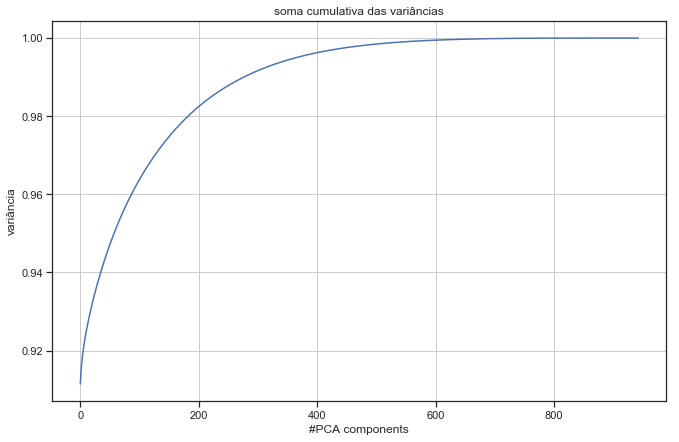

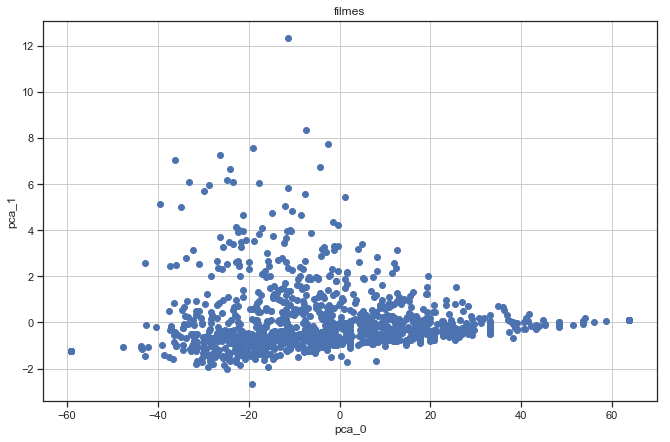

In [33]:
visualize_pca(X_pca_100k, pca_full_100k)

Observando o gráfico, percbe-se a concentração de enrgia nas primeiras componentes com apenas 3 temos que:

In [34]:
# limpando a memória
pca_full_100k = None
X_pca_100k = None

In [35]:
X_pca_100k, pca_reduced_100k = get_pca(X_train_100k, 70)

In [36]:
print("energia conservada pelas %i primeiras componentes do PCA %f" % (pca_reduced_100k.n_components, pca_reduced_100k.explained_variance_ratio_.sum())) 

energia conservada pelas 70 primeiras componentes do PCA 0.954364


In [37]:
X_test_pca_100k = pca_reduced_100k.transform(X_test_100k)

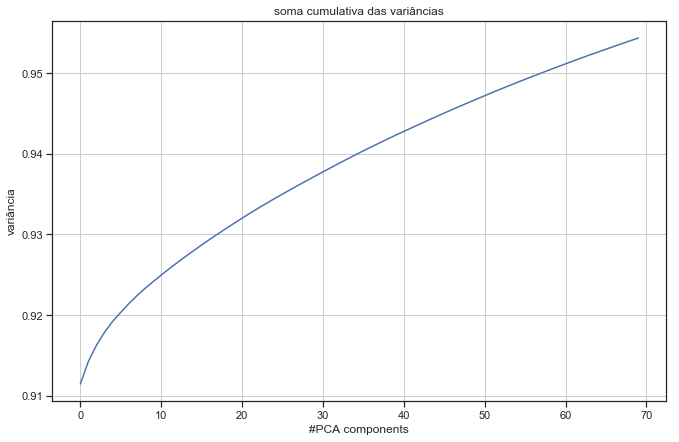

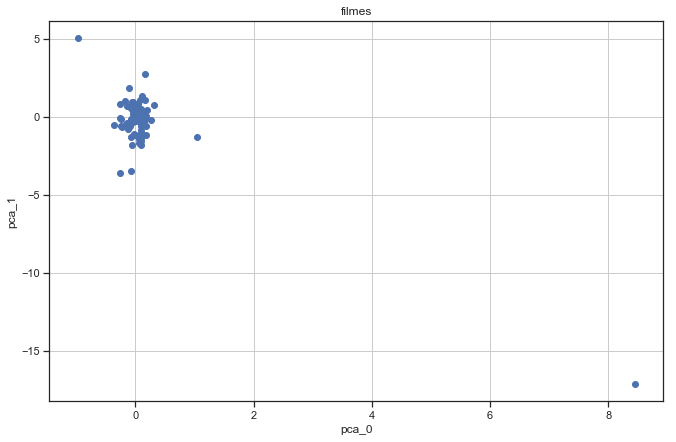

In [38]:
visualize_pca(X_test_pca_100k, pca_reduced_100k)

## Landmarkss

Para escolher os Landmarks, vou ordená-los por ordem decrescente de ordem L) (número de componentes não 0 do vetor)

In [39]:
def visualize_lca(df):
    plt.figure(),
    g = sns.pairplot( df, x_vars=df.columns, y_vars=df.columns)
    plt.show()

In [40]:
class LandmarksComponentAnalysis:
    
    def __init__(self, num_landmarks, metric, epsilon=1e-8):
        self.n_ = num_landmarks
        self.metric_ = metric
        self.epsilon_ = epsilon
    
    def select_most_seen_as_landmarks(self, filesDF_notFilled):
        most_seen_films = filesDF_notFilled.notna().sum(axis=1).sort_values(ascending=False)
        most_seen_films_idx = most_seen_films.index
        landmarks_idx = most_seen_films_idx[0:self.n_]
        return landmarks_idx
    
    def fit(self, sparseDF, featuresDF):
        selected_landmarks_ids = self.select_most_seen_as_landmarks(sparseDF)
        self.landmarks_ = featuresDF.loc[selected_landmarks_ids]
        return self
        
    def transform(self, data):
        self.epsilon_ = 1e-8
        
        dists = pairwise_distances(X=data, Y=self.landmarks_, metric=self.metric_)
        
        df_transformed_values = dists
        
        df_transformed = pd.DataFrame(data=df_transformed_values)
        df_transformed.index = data.index
        
        return df_transformed

In [41]:
#  def transform(self, data):
#         self.epsilon_ = 1e-8
        
#         dists = pairwise_distances(X=data, Y=self.landmarks_, metric=self.metric_)
        
#         inv_dists = 1/(dists + self.epsilon_)        
# #         df_transformed_values = inv_dists
        
# #         normalize
#         sum_invs_dists = inv_dists.sum(axis=1).reshape(-1,1)
#         df_transformed_values = inv_dists/sum_invs_dists # dists.divide(dists.sum(axis=1), axis=0)
        
# #         print(weights_values[0:5,:])
# #         df_transformed_values = np.matmul(weights_values, self.landmarks_.values)

#         df_transformed = pd.DataFrame(data=df_transformed_values)
#         df_transformed.index = data.index
        
#         return df_transformed

### Base 100k

In [42]:
lca_100k = LandmarksComponentAnalysis(20, 'euclidean').fit(X_train_sparse_100k, X_train_100k)

In [43]:
X_lca_train_100k = lca_100k.transform(X_train_100k)

In [44]:
landmarks_full = enrich_columns(lca_100k.landmarks_, to_enrich_100k)

Nomes do landmarks escolhidos

In [45]:
print(landmarks_full['movie_title'])

id
50                                 Star Wars (1977)
258                                  Contact (1997)
100                                    Fargo (1996)
294                                Liar Liar (1997)
286                     English Patient, The (1996)
288                                   Scream (1996)
1                                  Toy Story (1995)
121                   Independence Day (ID4) (1996)
174                  Raiders of the Lost Ark (1981)
127                           Godfather, The (1972)
7                             Twelve Monkeys (1995)
98                 Silence of the Lambs, The (1991)
117                                Rock, The (1996)
172                 Empire Strikes Back, The (1980)
313                                  Titanic (1997)
405                      Mission: Impossible (1996)
79                             Fugitive, The (1993)
210       Indiana Jones and the Last Crusade (1989)
151    Willy Wonka and the Chocolate Factory (1971)
173      

Visualizando as os calores das componentes na base

<Figure size 792x504 with 0 Axes>

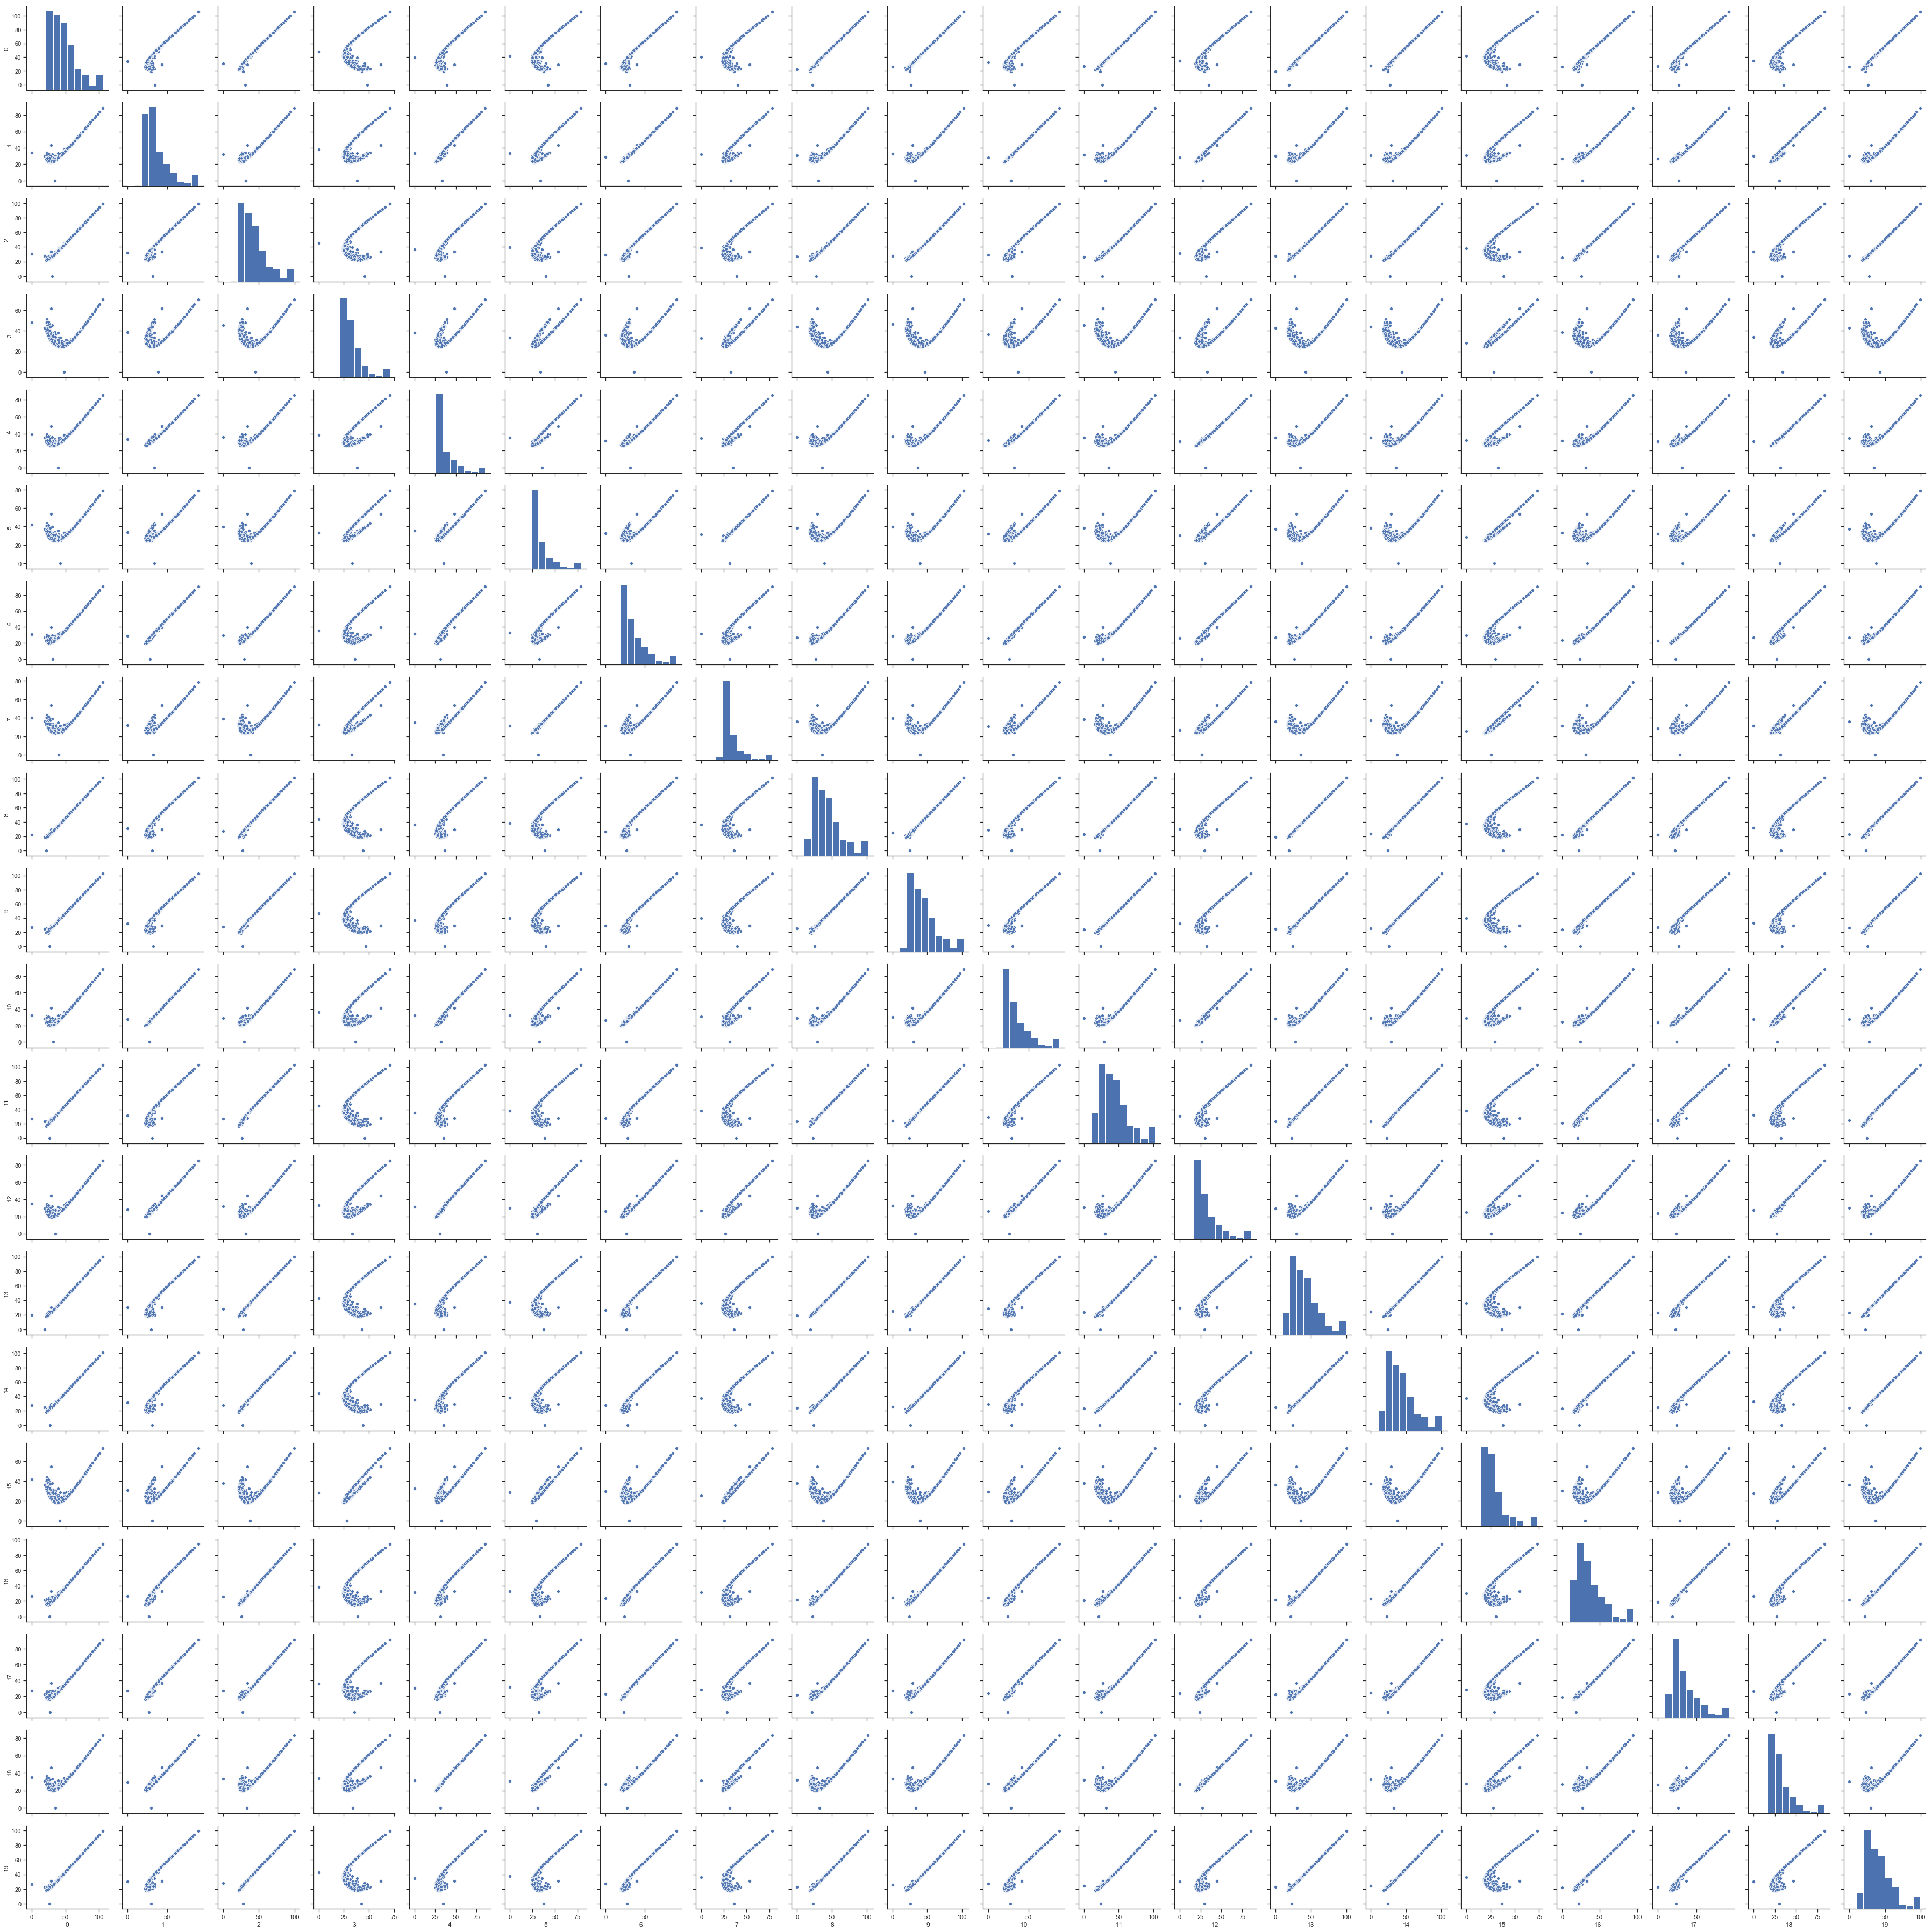

In [46]:
visualize_lca(X_lca_train_100k)

In [47]:
X_lca_test_100k = lca_100k.transform(X_test_100k)

<Figure size 792x504 with 0 Axes>

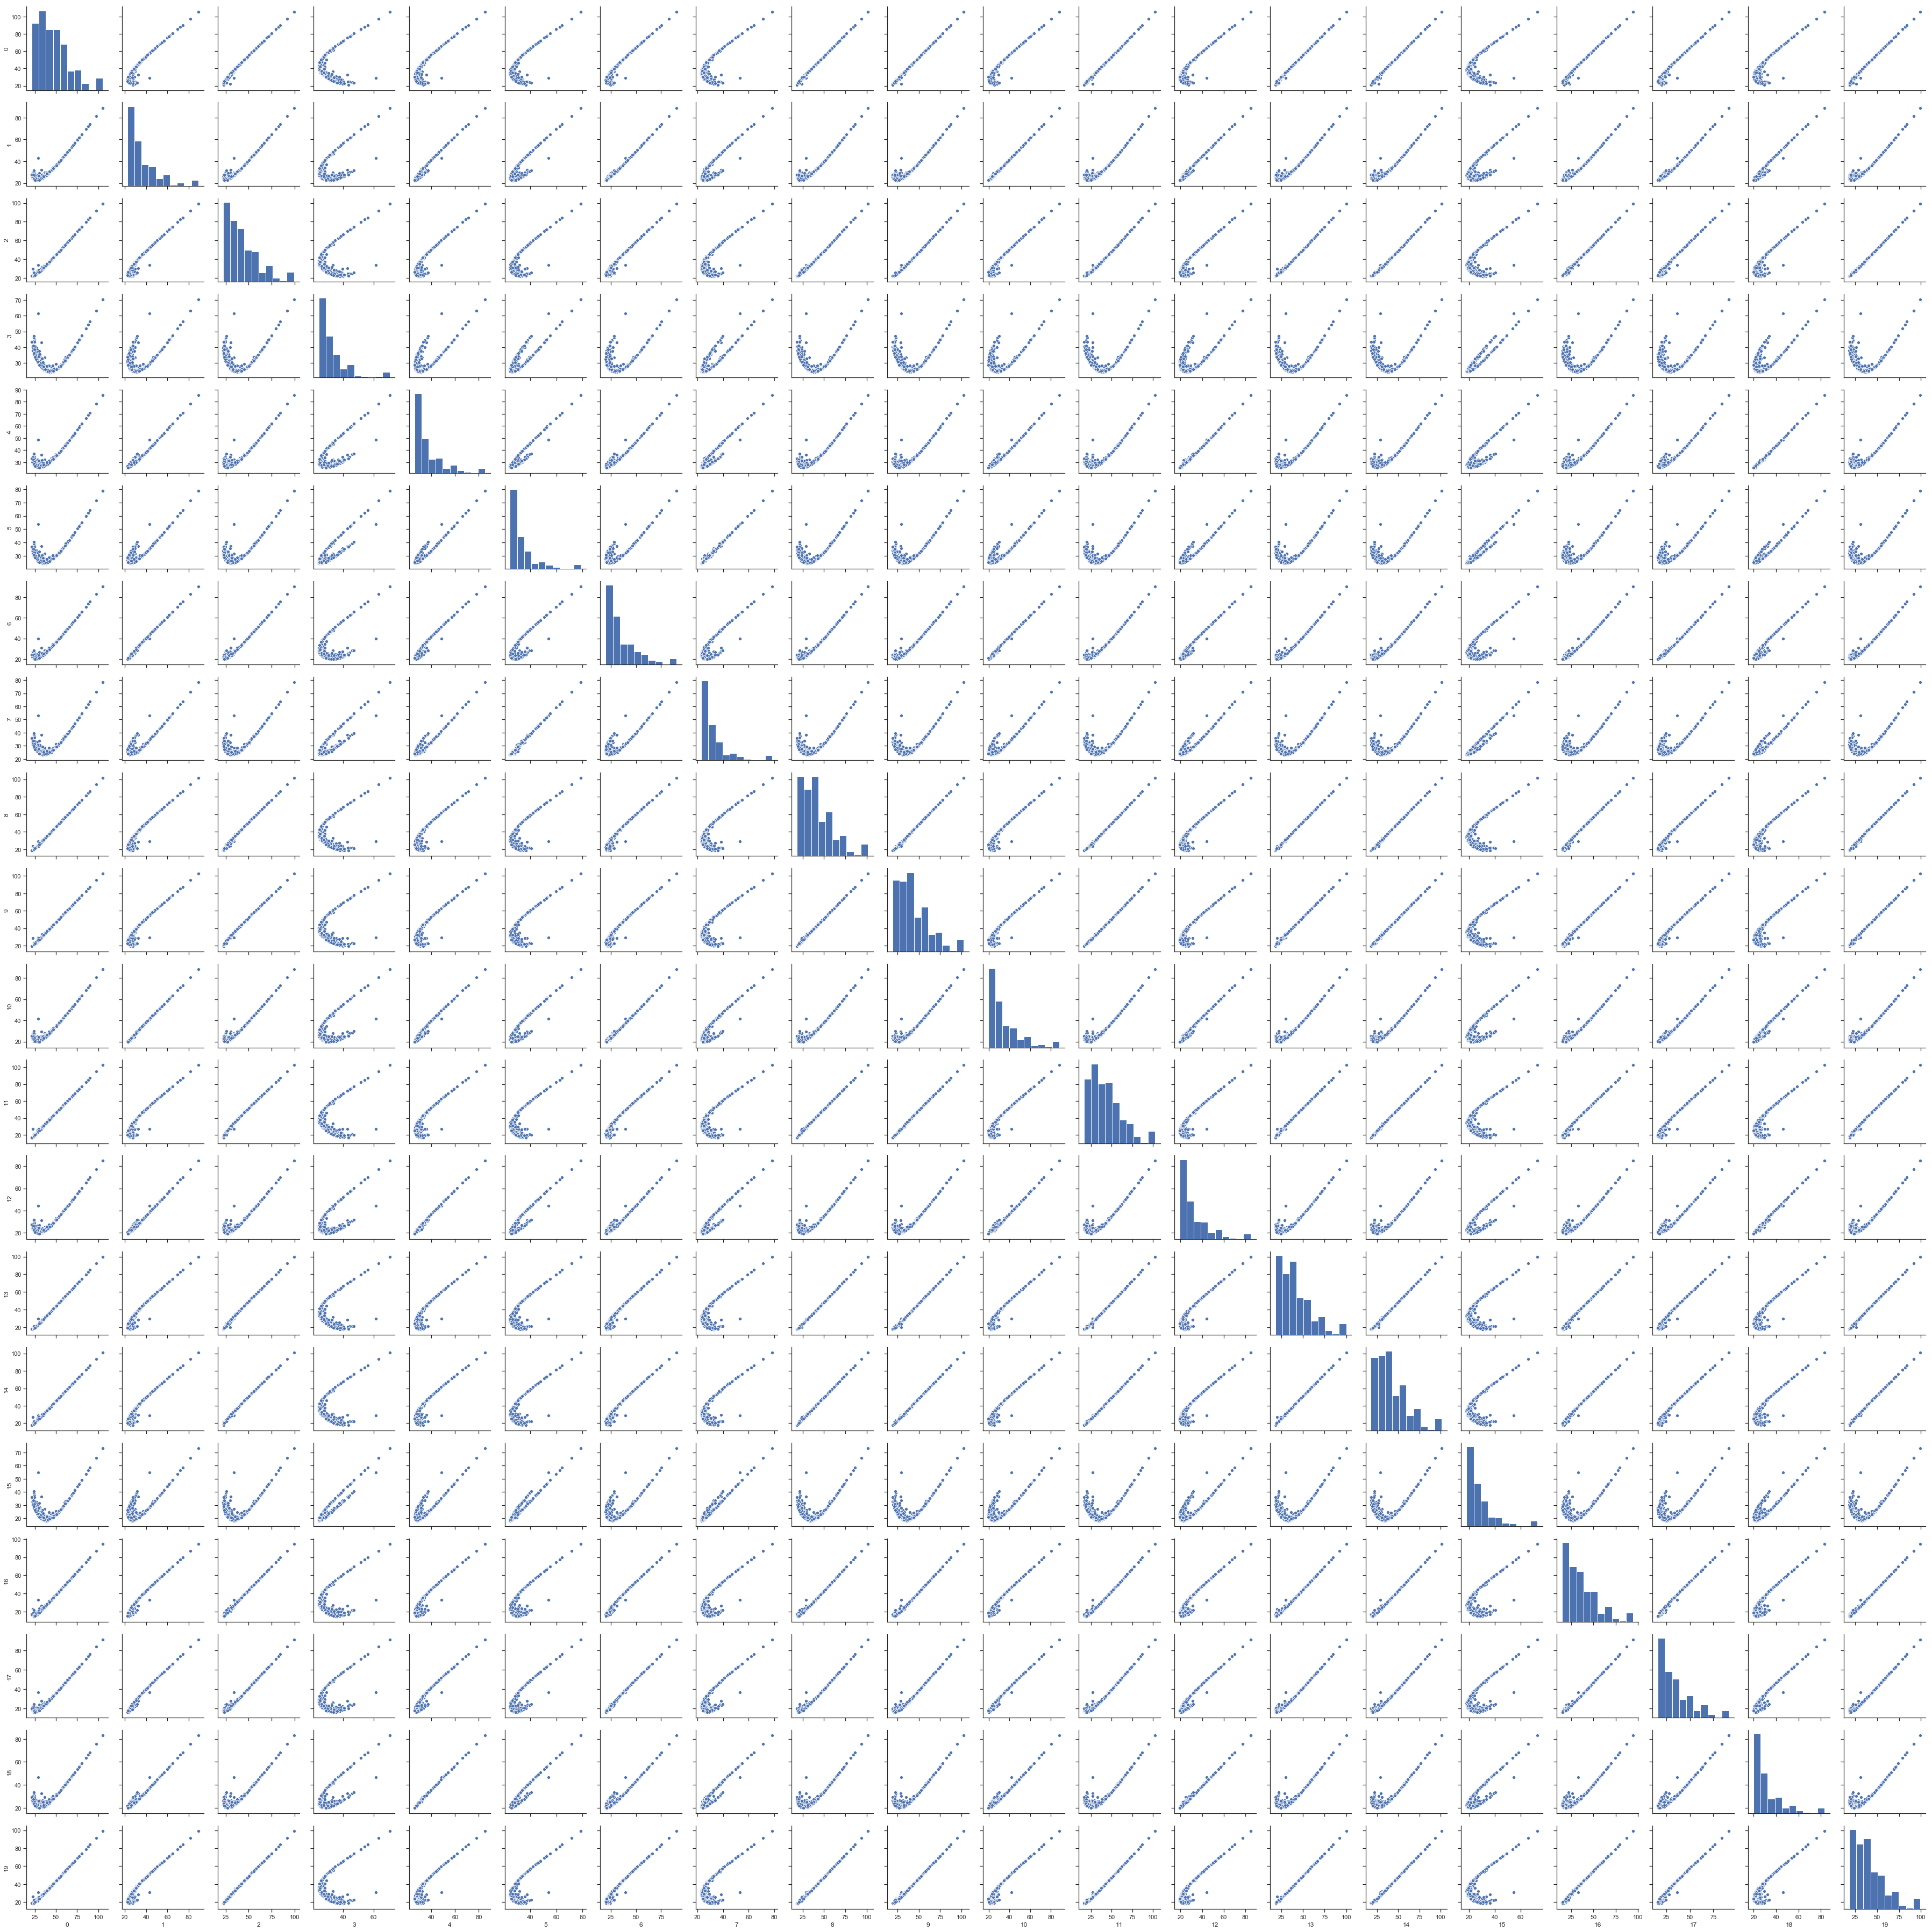

In [48]:
visualize_lca(X_lca_test_100k)

a dispersão entre teste e treino não deve ser tão diferente quanto se acredita em primeira vista, os outliers do conjuntode treino fazem a escla muito diferente

## K-NN Regression

In [52]:
def evaluate_knn_regressor( X_train, X_test, y_train, y_test, metric_='euclidean', n_weighboors=1):
    
    knnregressor = KNeighborsRegressor(n_neighbors=n_weighboors, weights="distance", metric=metric_)
    
    knnregressor.fit(X_train, y_train) # não deve fazer nada
    
    train_score = knnregressor.score(X_train, y_train)
    train_test = knnregressor.score(X_test, y_test)
    
    return knnregressor, train_score, train_test

In [53]:
n_weighboors = 5
metric='euclidean'
knn_regressor, train_score, test_score = evaluate_knn_regressor(
    X_lca_train_100k, X_lca_test_100k, 
    X_train_100k, X_test_100k,
    metric_=metric, n_weighboors=n_weighboors)

### Search optimum parameters

busca por varredura em escla log

In [54]:
import traceback 
def search_knn_hiperparams(X, params_ranges):
    
    y = X
    
    result  = pd.DataFrame(
        columns=["fold", "metrics", "n_components", "n_neighboors", "train_score", "test_score"]
    )

    # ranges
    metrics_values = params_ranges['metrics_values']
    n_components_values = params_ranges['n_components_values']
    n_neighboors_values = params_ranges['n_neighboors_values']
    
    # K-Fold
    kflod = KFold(n_splits=5, shuffle=True)
    
    fold = 0
    row = -1
    for train_index, test_index in kflod.split(X):
        fold = fold + 1
        
        # get train and test splits
        X_train_sparse, X_test_sparse = X.iloc[train_index], X.iloc[test_index]
        y_train_sparse, y_test_sparse = y.iloc[train_index], y.iloc[test_index]
        
        # fill na
        X_train = fillNa_with_non_na_avg_rating_for_film(X_train_sparse)
        y_train = fillNa_with_non_na_avg_rating_for_film(y_train_sparse)
        X_test = fillNa_with_non_na_avg_rating_for_film(X_test_sparse)
        y_test = fillNa_with_non_na_avg_rating_for_film(y_test_sparse)        
                
        for metric in metrics_values:
            print ("metric=%s" % metric)
            
            for n_components in tqdm(n_components_values):
                n_components = int(n_components)
                
                # Landmark analysis
                lca = LandmarksComponentAnalysis(n_components, metric).fit(X_train_sparse, X_train)
                
                X_train_lca = lca.transform(X_train)
                X_test_lca = lca.transform(X_test)

                for n_neighboors in n_neighboors_values:
                    n_neighboors = int(n_neighboors)
                    
                    row = row + 1
                    try:
                        knn_regressor, train_score, test_score = evaluate_knn_regressor(
                                                    X_train_lca, X_test_lca, 
                                                    y_train, y_test,
                                                    metric_=metric, n_weighboors=n_weighboors)
                    except Exception:
                        result.loc[row] =  [np.NaN, np.NaN, np.NaN,np.NaN,np.NaN,np.NaN]
#                         tb = traceback.format_exc()
#                         print(tb)
                        continue
                    
                    result.loc[row] = [fold, metric, n_components, n_neighboors, train_score, test_score] 
    
    return result

In [55]:
n_neighboors_values = np.array(list(set(np.rint(np.logspace(0, 2, 30)))))
# n_neighboors_values = np.array(list(set(np.rint(np.logspace(0, 1, 30)))))

In [56]:
n_components_values = np.array(list(set(np.rint(np.logspace(0, 3, 30)))))
# n_components_values = np.array(list(set(np.rint(np.logspace(0, 2, 30)))))

In [57]:
metric_values = ["euclidean", 'correlation', 'manhattan'] 

In [58]:
params = {
    "n_neighboors_values": n_neighboors_values,
    "n_components_values": n_components_values,
    "metrics_values": metric_values
}

In [59]:
%%time
result = search_knn_hiperparams(df_features_100k, params)

metric=euclidean


100%|██████████████████████████████████████████████████████| 27/27 [03:19<00:00, 10.33s/it]


metric=correlation


100%|██████████████████████████████████████████████████████| 27/27 [00:12<00:00,  1.31it/s]


metric=manhattan


100%|██████████████████████████████████████████████████████| 27/27 [02:42<00:00,  7.64s/it]


metric=euclidean


100%|██████████████████████████████████████████████████████| 27/27 [03:17<00:00, 10.07s/it]


metric=correlation


100%|██████████████████████████████████████████████████████| 27/27 [00:11<00:00,  1.37it/s]


metric=manhattan


100%|██████████████████████████████████████████████████████| 27/27 [02:43<00:00,  7.75s/it]


metric=euclidean


100%|██████████████████████████████████████████████████████| 27/27 [03:17<00:00, 10.29s/it]


metric=correlation


100%|██████████████████████████████████████████████████████| 27/27 [00:11<00:00,  1.36it/s]


metric=manhattan


100%|██████████████████████████████████████████████████████| 27/27 [02:47<00:00,  7.76s/it]


metric=euclidean


100%|██████████████████████████████████████████████████████| 27/27 [03:22<00:00, 10.32s/it]


metric=correlation


100%|██████████████████████████████████████████████████████| 27/27 [00:12<00:00,  1.32it/s]


metric=manhattan


100%|██████████████████████████████████████████████████████| 27/27 [02:38<00:00,  7.44s/it]


metric=euclidean


100%|██████████████████████████████████████████████████████| 27/27 [03:21<00:00, 10.33s/it]


metric=correlation


100%|██████████████████████████████████████████████████████| 27/27 [00:12<00:00,  1.27it/s]


metric=manhattan


100%|██████████████████████████████████████████████████████| 27/27 [02:44<00:00,  7.67s/it]


Wall time: 31min 19s


In [ ]:
%%time
result_1M = search_knn_hiperparams(df_features_1M, params)

metric=euclidean


 81%|████████████████████████████████████████████          | 22/27 [21:23<04:51, 58.26s/it]

In [ ]:
result.to_pickle('knn_landmark_result_100k.pkl')
result_1M.to_pickle('knn_landmark_result_1M.pkl')

## PCA

In [ ]:
def search_pca_knn(X, params_ranges):
    
    y = X
    
    result  = pd.DataFrame(
        columns=["fold", "metrics", "n_components", "n_neighboors", "train_score", "test_score"]
    )

    # ranges
    metrics_values = params_ranges['metrics_values']
    n_components_values = params_ranges['n_components_values']
    n_neighboors_values = params_ranges['n_neighboors_values']
    
    # K-Fold
    kflod = KFold(n_splits=5, shuffle=True)
    
    fold = 0
    row = -1
    for train_index, test_index in kflod.split(X):
        fold = fold + 1
        
        # get train and test splits
        X_train_sparse, X_test_sparse = X.iloc[train_index], X.iloc[test_index]
        y_train_sparse, y_test_sparse = y.iloc[train_index], y.iloc[test_index]
        
        # fill na
        X_train = fillNa_with_non_na_avg_rating_for_film(X_train_sparse)
        y_train = fillNa_with_non_na_avg_rating_for_film(y_train_sparse)
        X_test = fillNa_with_non_na_avg_rating_for_film(X_test_sparse)
        y_test = fillNa_with_non_na_avg_rating_for_film(y_test_sparse)        
            
        for n_components in tqdm(n_components_values):
            n_components = int(n_components)

            # Landmark analysis
            lca = PCA(n_components=n_components).fit(X_train)

            X_train_pca = lca.transform(X_train)
            X_test_pca = lca.transform(X_test)

            for n_neighboors in n_neighboors_values:
                n_neighboors = int(n_neighboors)

                row = row + 1
                try:
                    knn_regressor, train_score, test_score = evaluate_knn_regressor(
                                                X_train_pca, X_test_pca, 
                                                y_train, y_test,
                                                metric_=metric, n_weighboors=n_weighboors)
                except Exception:
                    result.loc[row] =  [np.NaN, np.NaN, np.NaN,np.NaN,np.NaN,np.NaN]
#                         tb = traceback.format_exc()
#                         print(tb)
                    continue

                result.loc[row] = [fold, metric, n_components, n_neighboors, train_score, test_score] 
    
    return result

In [ ]:
result_100k_pca = search_pca_knn(df_features_100k, params)

In [ ]:
result_1M_pca = search_pca_knn(df_features_1M, params)